# Kaggle Fraud Dataset  
source: [www.kaggle.com/datasets/fraud.csv](https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction/data)

| Feature | Description |
|---------|-------------|
|**step**| maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).| 
|**type**| CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.| 
|**amount**| amount of the transaction in local currency.| 
|**nameOrig**| customer who started the transaction| 
|**oldbalanceOrg**| initial balance before the transaction| 
|**newbalanceOrig**| new balance after the transaction| 
|**nameDest**| customer who is the recipient of the transaction| 
|**oldbalanceDest**| initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).| 
|**newbalanceDest**| new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).| 
|**isFraud**| This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.|  
|**isFlaggedFraud**| The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.| 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker

from sklearn import metrics 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression 
from sklearn import svm

from yellowbrick.classifier import (
    ClassificationReport,
    DiscriminationThreshold,
    PrecisionRecallCurve
)

from feature_engine import encoding as ce
from imblearn.over_sampling import SMOTE, SVMSMOTE

from xgboost import XGBClassifier, XGBRFClassifier 

import optuna
from optuna.storages import RDBStorage
# from optuna_dashboard import wsgi

storage = RDBStorage("sqlite:///db.sqlite3")
# application = wsgi(storage)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load data

In [17]:
df = pd.read_csv('Fraud.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [57]:
print(f"Number of customers: {df.shape[0]:,.0f}")
print(f"nameOrig: {df['nameOrig'].nunique():,.0f}")
print(f"nameDest: {df['nameDest'].nunique():,.0f}")

Number of customers: 6,362,620
nameOrig: 6,353,307
nameDest: 2,722,362


In [18]:
# Imbalance of target 
print(df['isFraud'].value_counts(dropna=False))
print(df['isFraud'].value_counts(normalize=True, dropna=False))

0    6354407
1       8213
Name: isFraud, dtype: int64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [19]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [20]:
df.groupby('type')['type'].count()

type
CASH_IN     1399284
CASH_OUT    2237500
DEBIT         41432
PAYMENT     2151495
TRANSFER     532909
Name: type, dtype: int64

In [49]:
df['nameOrig_tf'] = [i[0:2] for i in df['nameOrig']]
df.groupby('nameOrig_tf')['isFraud'].agg(['mean', 'count']).sort_values(by='mean')

,mean,count
nameOrig_tf,,
C2,0.001200,766936
C5,0.001218,330009
C6,0.001230,329312
C8,0.001240,328926
C4,0.001267,329176
C7,0.001307,330560
C3,0.001314,327938
C1,0.001319,3290968
C9,0.001387,328795


In [47]:
df['nameDest_tf'] = [i[0:2] for i in df['nameDest']]
df.groupby('nameDest_tf')['isFraud'].agg(['mean', 'count']).sort_values(by='mean')

,mean,count
nameDest_tf,,
M9,0.000000,111700
M7,0.000000,111760
M6,0.000000,110943
M5,0.000000,111343
M4,0.000000,111116
M3,0.000000,111298
M2,0.000000,258735
M8,0.000000,111350
M1,0.000000,1113250


In [43]:
df = pd.read_csv('Fraud.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(['isFraud', 'isFlaggedFraud'], axis=1),
                                                    df['isFraud'],
                                                    test_size=0.2,
                                                    stratify=df['isFraud'],
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 9), (1272524, 9), (5090096,), (1272524,))

In [44]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998709
1    0.001291
Name: isFraud, dtype: float64
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


## Set up preprocessing pipeline

In [10]:
def preprocessing(X):
    
    X['nameOrig'] = [i[0:2] for i in X['nameOrig']]
    X['nameDest'] = [i[0:2] for i in X['nameDest']]
    return X

In [11]:
def performance(X, y, model, title=None):

    # Predict probabilities on the test set
    y_probs = model.predict_proba(X)[:, 1]
    y_preds = model.predict(X)

    # Calculate evaluation metrics
    roc_auc = metrics.roc_auc_score(y, y_probs)
    precision = metrics.precision_score(y, y_preds)
    recall = metrics.recall_score(y, y_preds)
    f1 = metrics.f1_score(y, y_preds)
    aupr = metrics.average_precision_score(y, y_probs)

    if title is None:
        title = 'Performance metrics:'
    else:
        title = f'Performance metrics: {title}'
    print(title)
    print("ROC AUC:".ljust(10) + f"{roc_auc:.2%}".rjust(8))
    print("Precision:".ljust(10) + f"{precision:.2%}".rjust(8))
    print("Recall:".ljust(10) + f"{recall:.2%}".rjust(8))
    print("F1:".ljust(10) + f"{f1:.2%}".rjust(8))
    print("AUPRC:".ljust(10) + f"{aupr:.2%}".rjust(8))
    print()

In [47]:
encoder = ce.OrdinalEncoder(encoding_method='ordered', 
                            variables=['type', 'nameOrig', 'nameDest'])

In [50]:
X_train = preprocessing(X_train)
X_train = encoder.fit_transform(X_train, y_train)
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
292779,15,2,9914.74,4,44248.00,34333.26,7,0.00,0.00
499763,20,2,6854.53,6,0.00,0.00,7,0.00,0.00
2970411,231,3,361211.80,2,0.00,0.00,12,489745.16,850956.95
3137549,236,2,7083.51,6,0.00,0.00,7,0.00,0.00
1500682,143,0,218019.51,6,13045685.58,13263705.09,16,2438123.98,2220104.47


In [57]:
model = XGBClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [58]:
performance(X_train, y_train, model, title='X_train')

Performance metrics: X_train
ROC AUC:   100.00%
Precision:  98.43%
Recall:     90.49%
F1:         94.29%
AUPRC:      98.86%



In [55]:
X_test = preprocessing(X_test)
X_test = encoder.transform(X_test)
X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
4051353,300,4,890577.21,6,218.00,0.00,16,0.00,890577.21
5746321,399,0,97734.24,6,2096258.84,2193993.08,12,320136.00,222401.76
6361797,718,2,5907.41,6,315.00,0.00,7,0.00,0.00
2247309,186,3,187696.30,6,11057.00,0.00,12,1798095.21,1985791.51
4692207,331,3,82646.52,0,0.00,0.00,12,1047805.87,1130452.39


In [59]:
performance(X_test, y_test, model, title='X_test')

Performance metrics: X_test
ROC AUC:    99.99%
Precision:  95.94%
Recall:     84.84%
F1:         90.05%
AUPRC:      96.76%



In [61]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [62]:
performance(X_train, y_train, model_lr, title='X_train')
performance(X_test, y_test, model_lr, title='X_test')

Performance metrics: X_train
ROC AUC:    86.04%
Precision:  79.30%
Recall:     44.44%
F1:         56.96%
AUPRC:      45.95%

Performance metrics: X_test
ROC AUC:    86.42%
Precision:  79.63%
Recall:     44.49%
F1:         57.09%
AUPRC:      46.27%



## Machine-learning pipeline & k-fold cross-validation

In [68]:
df = pd.read_csv('Fraud.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(['isFraud', 'isFlaggedFraud'], axis=1),
                                                    df['isFraud'],
                                                    test_size=0.2,
                                                    stratify=df['isFraud'],
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 9), (1272524, 9), (5090096,), (1272524,))

In [95]:
fraud_pipeline = Pipeline([
    
    # transform Origname and Destname to less granular features
   ('orig_dest_transformation', FunctionTransformer(preprocessing)),

    # categorical encoding
    ('encoder_categorical',ce.OrdinalEncoder(encoding_method='ordered',
                                             variables=['type', 'nameOrig', 'nameDest'])),
    
    # Extreme Gradiant Boosting model    
    # ('model', XGBClassifier(n_jobs=-1, random_state=42))
])

In [96]:
X_train = fraud_pipeline.fit_transform(X_train, y_train)
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
292779,15,2,9914.74,4,44248.00,34333.26,7,0.00,0.00
499763,20,2,6854.53,6,0.00,0.00,7,0.00,0.00
2970411,231,3,361211.80,2,0.00,0.00,12,489745.16,850956.95
3137549,236,2,7083.51,6,0.00,0.00,7,0.00,0.00
1500682,143,0,218019.51,6,13045685.58,13263705.09,16,2438123.98,2220104.47


In [97]:
X_test = fraud_pipeline.transform(X_test)
X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
4051353,300,4,890577.21,6,218.00,0.00,16,0.00,890577.21
5746321,399,0,97734.24,6,2096258.84,2193993.08,12,320136.00,222401.76
6361797,718,2,5907.41,6,315.00,0.00,7,0.00,0.00
2247309,186,3,187696.30,6,11057.00,0.00,12,1798095.21,1985791.51
4692207,331,3,82646.52,0,0.00,0.00,12,1047805.87,1130452.39


In [23]:
# weight will be used as a hyperparameter to offset the class imbalance
weight = len(y_train[y_train==0]) // len(y_train[y_train==1])
weight

773

In [80]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.11),
        'max_depth' : trial.suggest_int('max_depth', 2, 10),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1, weight)
    }

    model = XGBClassifier(**params,n_jobs=-1, random_state=42)

    # Calculate F1 score using cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    f1_mean = scores.mean()  # Take the mean F1 score

    return f1_mean

In [82]:
study = optuna.create_study(
    storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
    study_name="Kaggle_Fraud_1",
    direction='maximize',
    sampler=optuna.samplers.RandomSampler(seed=42),
    load_if_exists=True
)
study.optimize(objective, n_trials=200)
print(f"Best value: {study.best_value} (params: {study.best_params})")

[I 2024-03-09 20:54:53,652] A new study created in RDB with name: KDD_Cup_2004_1
[I 2024-03-09 20:57:20,169] Trial 0 finished with value: 0.7595636910061376 and parameters: {'n_estimators': 250, 'learning_rate': 0.10507143064099161, 'max_depth': 8, 'scale_pos_weight': 463.16434980011223}. Best is trial 0 with value: 0.7595636910061376.
[I 2024-03-09 20:58:10,637] Trial 1 finished with value: 0.04989737556533853 and parameters: {'n_estimators': 162, 'learning_rate': 0.025599452033620268, 'max_depth': 2, 'scale_pos_weight': 669.6879845382499}. Best is trial 0 with value: 0.7595636910061376.
[I 2024-03-09 20:59:42,429] Trial 2 finished with value: 0.12874733437154368 and parameters: {'n_estimators': 341, 'learning_rate': 0.08080725777960454, 'max_depth': 2, 'scale_pos_weight': 749.7704058690596}. Best is trial 0 with value: 0.7595636910061376.
[I 2024-03-09 21:01:54,247] Trial 3 finished with value: 0.3297701016719637 and parameters: {'n_estimators': 433, 'learning_rate': 0.03123391106782

Best value: 0.8854823732036611 (params: {'n_estimators': 477, 'learning_rate': 0.10539285770025873, 'max_depth': 10, 'scale_pos_weight': 286.76251659720305})


In [84]:
# best choice of provided hyperparameters
params = study.best_params
params

{'n_estimators': 477,
 'learning_rate': 0.10539285770025873,
 'max_depth': 10,
 'scale_pos_weight': 286.76251659720305}

In [85]:
model_xgb = XGBClassifier(**params, n_jobs=-1, random_state=42)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10539285770025873,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=477, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [86]:
performance(X_train, y_train, model_xgb, title='X_train')
performance(X_test, y_test, model_xgb, title='X_test')

Performance metrics: X_train
ROC AUC:   100.00%
Precision:  97.05%
Recall:    100.00%
F1:         98.50%
AUPRC:     100.00%

Performance metrics: X_test
ROC AUC:    99.98%
Precision:  85.64%
Recall:     92.21%
F1:         88.80%
AUPRC:      96.49%



In [87]:
# XGBoost: default parameters
performance(X_train, y_train, model, title='X_train')
performance(X_test, y_test, model, title='X_test')

Performance metrics: X_train
ROC AUC:   100.00%
Precision:  98.43%
Recall:     90.49%
F1:         94.29%
AUPRC:      98.86%

Performance metrics: X_test
ROC AUC:    99.99%
Precision:  95.94%
Recall:     84.84%
F1:         90.05%
AUPRC:      96.76%



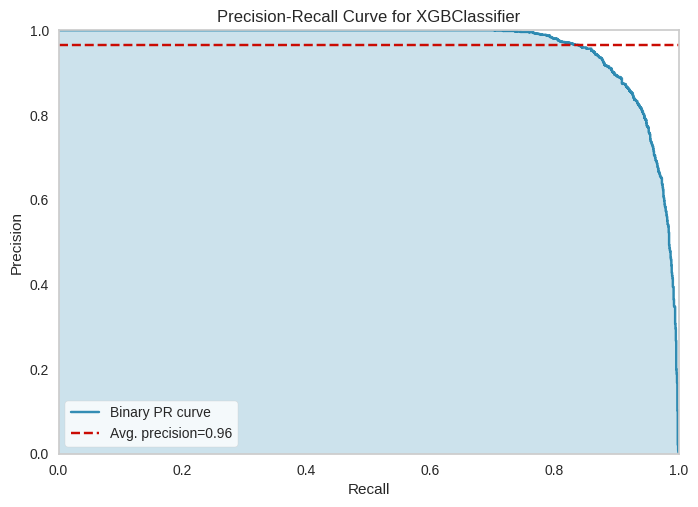

In [90]:
visualizer = PrecisionRecallCurve(model_xgb, classes=[0, 1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and show the figure

In [ ]:
visualizer = DiscriminationThreshold(model_xgb,
                                     n_trials=10,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [100]:
model = XGBClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.85      0.90      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.92      0.95   1272524
weighted avg       1.00      1.00      1.00   1272524



## SMOTE

In [2]:
df = pd.read_csv('Fraud.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(['isFraud', 'isFlaggedFraud'], axis=1),
                                                    df['isFraud'],
                                                    test_size=0.2,
                                                    stratify=df['isFraud'],
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 9), (1272524, 9), (5090096,), (1272524,))

In [3]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
292779,15,PAYMENT,9914.74,C482751146,44248.00,34333.26,M1651188591,0.00,0.00
499763,20,PAYMENT,6854.53,C188264521,0.00,0.00,M1469015863,0.00,0.00
2970411,231,CASH_OUT,361211.80,C593201095,0.00,0.00,C1985763166,489745.16,850956.95
3137549,236,PAYMENT,7083.51,C1617277615,0.00,0.00,M1529547196,0.00,0.00
1500682,143,CASH_IN,218019.51,C1705563354,13045685.58,13263705.09,C2121401221,2438123.98,2220104.47


In [4]:
columns_to_scale = X_train.columns.to_list()
columns_to_scale

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest']

In [8]:
def to_dataframe(X):
    return pd.DataFrame(X, columns=columns_to_scale)

In [12]:
pipe = Pipeline([
    
    # transform Origname and Destname to less granular features
   ('orig_dest_transformation', FunctionTransformer(preprocessing)),

    # categorical encoding
    ('encoder_categorical',ce.OrdinalEncoder(encoding_method='ordered',
                                             variables=['type', 'nameOrig', 'nameDest'])),

    # scale specific variables
    ('scaler', MinMaxScaler()), 

    # transform to dataframe again with original feature order preserved
    ('to_dataframe', FunctionTransformer(to_dataframe)),  
])

In [13]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('orig_dest_transformation',
                 FunctionTransformer(func=<function preprocessing at 0x7fde80ee98b0>)),
                ('encoder_categorical',
                 OrdinalEncoder(variables=['type', 'nameOrig', 'nameDest'])),
                ('scaler', MinMaxScaler()),
                ('to_dataframe',
                 FunctionTransformer(func=<function to_dataframe at 0x7fdf2ca2b160>))])

In [10]:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [11]:
X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,0.402965,1.00,0.009634,0.75,0.000004,0.000000,0.941176,0.000000,0.002500
1,0.536388,0.00,0.001057,0.75,0.035181,0.044247,0.705882,0.000899,0.000624
2,0.966307,0.50,0.000064,0.75,0.000005,0.000000,0.411765,0.000000,0.000000
3,0.249326,0.75,0.002030,0.75,0.000186,0.000000,0.705882,0.005051,0.005575
4,0.444744,0.75,0.000894,0.00,0.000000,0.000000,0.705882,0.002943,0.003174


In [12]:
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=42,  
    k_neighbors=5,
    # n_jobs=4
)

svmsm = SVMSMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=42,  # for reproducibility
    k_neighbors=5, # neighbours to create the synthetic examples
    m_neighbors=10, # neighbours to determine if minority class is in "critical zone"
    # n_jobs=-1,
    svm_estimator = svm.SVC(kernel='linear')
)

X_train_res, y_train_res =  svmsm.fit_resample(X_train, y_train)

In [13]:
y_train_res.value_counts()

isFraud
0    5083526
1    5083526
Name: count, dtype: int64

In [159]:
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.90      0.04      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.93      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524



--- 

In [14]:
df = pd.read_csv('Fraud.csv')
X_train, X_test, y_train, y_test = train_test_split(df.drop(['isFraud', 'isFlaggedFraud'], axis=1),
                                                    df['isFraud'],
                                                    test_size=0.2,
                                                    stratify=df['isFraud'],
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5090096, 9), (1272524, 9), (5090096,), (1272524,))

In [15]:
columns_to_scale = [var for var in X_train.columns if X_train[var].dtype != 'O']
columns_to_scale

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [16]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_scale):
        self.columns_to_scale = columns_to_scale
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns_to_scale])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.columns_to_scale] = self.scaler.transform(X[self.columns_to_scale])
        return X_scaled

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [17]:
pipe = Pipeline([

    # transform Origname and Destname to less granular features
   ('orig_dest_transformation', FunctionTransformer(preprocessing)),

    # categorical encoding
    ('encoder_categorical',ce.OrdinalEncoder(encoding_method='ordered',
                                             variables=['type', 'nameOrig', 'nameDest'])),

    # scale numerical variables
    ('scaler', CustomScaler(columns_to_scale=columns_to_scale))
])

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('orig_dest_transformation',
                 FunctionTransformer(func=<function preprocessing at 0x7fde80ee98b0>)),
                ('encoder_categorical',
                 OrdinalEncoder(variables=['type', 'nameOrig', 'nameDest'])),
                ('scaler',
                 CustomScaler(columns_to_scale=['step', 'amount',
                                                'oldbalanceOrg',
                                                'newbalanceOrig',
                                                'oldbalanceDest',
                                                'newbalanceDest']))])

In [19]:
# show the values from the categorical encoder
category_mappings = pipe.named_steps['encoder_categorical']
category_mappings.encoder_dict_

{'type': {'CASH_IN': 0,
  'DEBIT': 1,
  'PAYMENT': 2,
  'CASH_OUT': 3,
  'TRANSFER': 4},
 'nameOrig': {'C2': 0,
  'C8': 1,
  'C5': 2,
  'C6': 3,
  'C4': 4,
  'C9': 5,
  'C1': 6,
  'C3': 7,
  'C7': 8},
 'nameDest': {'M9': 0,
  'M7': 1,
  'M6': 2,
  'M5': 3,
  'M4': 4,
  'M3': 5,
  'M8': 6,
  'M1': 7,
  'M2': 8,
  'C7': 9,
  'C3': 10,
  'C9': 11,
  'C1': 12,
  'C4': 13,
  'C6': 14,
  'C8': 15,
  'C2': 16,
  'C5': 17}}

In [64]:
y_train.groupby(X_train['nameDest']).agg(['mean', 'count']).sort_values(by='mean', ascending=True)

,mean,count
nameDest,,
M9,0.000000,89342
M7,0.000000,89573
M6,0.000000,88829
M5,0.000000,88979
M4,0.000000,88952
M3,0.000000,88932
M8,0.000000,89136
M1,0.000000,890338
M2,0.000000,207153


In [20]:
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [21]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
292779,0.018868,2,0.000107,4,0.000743,0.000692,7,0.000000,0.000000
499763,0.025606,2,0.000074,6,0.000000,0.000000,7,0.000000,0.000000
2970411,0.309973,3,0.003907,2,0.000000,0.000000,12,0.001376,0.002389
3137549,0.316712,2,0.000077,6,0.000000,0.000000,7,0.000000,0.000000
1500682,0.191375,0,0.002358,6,0.218942,0.267494,16,0.006848,0.006233


In [22]:
X_test.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
4051353,0.402965,4,0.009634,6,0.000004,0.000000,16,0.000000,0.002500
5746321,0.536388,0,0.001057,6,0.035181,0.044247,12,0.000899,0.000624
6361797,0.966307,2,0.000064,6,0.000005,0.000000,7,0.000000,0.000000
2247309,0.249326,3,0.002030,6,0.000186,0.000000,12,0.005051,0.005575
4692207,0.444744,3,0.000894,0,0.000000,0.000000,12,0.002943,0.003174


In [ ]:
# model = XGBClassifier(n_jobs=-1, random_state=42)
model = svm.SVC(kernel='rbf', gamma=1.00)
model.fit(X_train, y_train)
print(metrics.classification_report(y_train, model.predict(X_train)))

In [68]:
model = XGBClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [69]:
performance(X_train, y_train, model, title='X_train')
performance(X_test, y_test, model, title='X_test')

Performance metrics: X_train
ROC AUC:   100.00%
Precision:  99.32%
Recall:     90.90%
F1:         94.92%
AUPRC:      99.14%

Performance metrics: X_test
ROC AUC:    99.99%
Precision:  96.69%
Recall:     87.22%
F1:         91.71%
AUPRC:      97.63%



In [71]:
# Extract feature importance
feature_importance = model.get_booster().get_score(importance_type='weight')

The two feature importance measures you mentioned, `get_score(importance_type='weight')` and `feature_importances_`, come from different ways of calculating feature importance in XGBoost models.

1. **`get_score(importance_type='weight')`:**
   - This method calculates feature importance based on the number of times a feature is used to split the data across all the trees in the ensemble.
   - It counts how many times each feature appears in all the split decisions and sums up these counts to determine the importance.
   - This importance type is sometimes referred to as "frequency" or "occurrence" because it measures how often a feature is used for splitting.

2. **`feature_importances_`:**
   - This attribute directly calculates feature importance from the average gain (or improvement in accuracy) of each feature across all the trees in the ensemble.
   - It computes the average gain of each feature by considering how much each feature contributes to reducing the impurity (e.g., Gini impurity or entropy) when it is used for splitting.
   - This importance type is more focused on the quality of splits and how much each feature contributes to improving the model's performance.

**Key Differences:**
- The `get_score(importance_type='weight')` method measures feature importance based on the frequency of feature usage in splitting, while `feature_importances_` calculates it based on the improvement in model performance.
- `get_score(importance_type='weight')` is based on the number of times a feature is used for splitting, regardless of the quality of those splits, whereas `feature_importances_` considers the quality of splits by measuring the average gain.
- As a result, `get_score(importance_type='weight')` may be more influenced by the frequency of categorical variables with many levels, while `feature_importances_` focuses on the contribution of features to the model's predictive performance.

In practice, both measures provide valuable insights into feature importance, but they may prioritize different types of features or behaviors in the model. It's often a good idea to consider both measures to gain a comprehensive understanding of feature importance in an XGBoost model.

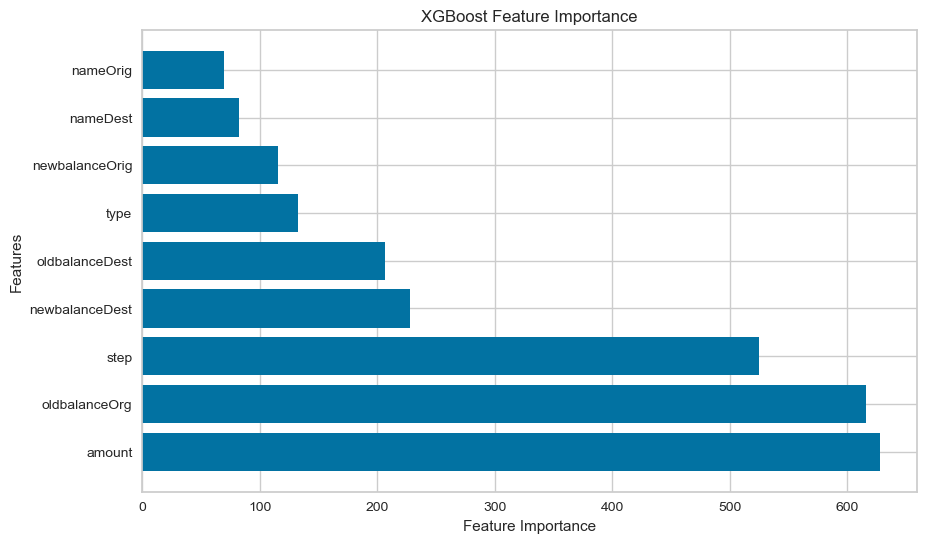

In [72]:
# Plot feature importance
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.show()

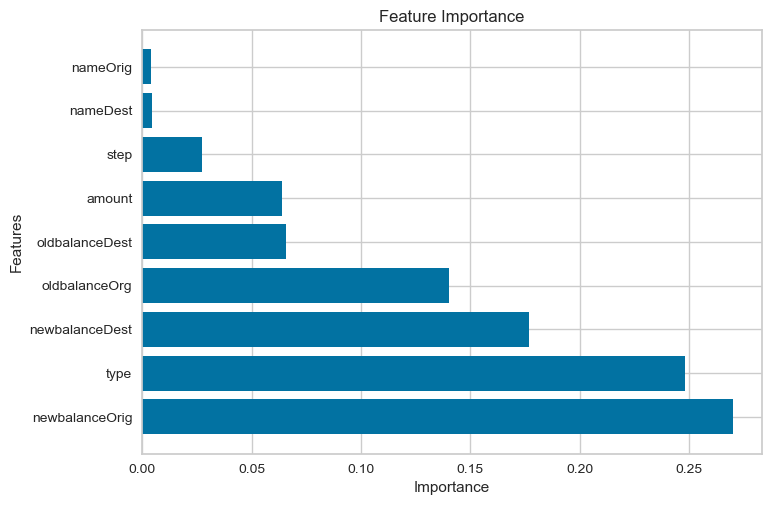

In [84]:
# Get feature importances
feature_importances = model.feature_importances_

fi = pd.DataFrame({'feature':X_train.columns.tolist(),
                   'importance':feature_importances})
fi = fi.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.barh(fi['feature'], fi['importance'])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

In [40]:
print(f"n_estimators: {model.get_params().get('n_estimators')}")
print(f"learning_rate: {model.get_params().get('learning_rate', 0.3)}")

n_estimators: 100
learning_rate: None


In [28]:
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [141]:
model = XGBRFClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=-1, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=42,
                reg_alpha=None, ...)

In [142]:
performance(X_train, y_train, model, title='X_train')
performance(X_test, y_test, model, title='X_test')

Performance metrics: X_train
ROC AUC:    99.10%
Precision:  97.92%
Recall:     68.93%
F1:         80.91%
AUPRC:      78.52%

Performance metrics: X_test
ROC AUC:    99.21%
Precision:  97.78%
Recall:     69.75%
F1:         81.42%
AUPRC:      78.83%



In [143]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [144]:
performance(X_train, y_train, model, title='X_train')
performance(X_test, y_test, model, title='X_test')

Performance metrics: X_train
ROC AUC:    93.17%
Precision:  98.62%
Recall:      8.69%
F1:         15.97%
AUPRC:      26.00%

Performance metrics: X_test
ROC AUC:    93.31%
Precision:  97.14%
Recall:      8.28%
F1:         15.26%
AUPRC:      25.08%



In [145]:
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=42,  
    k_neighbors=5,
    # n_jobs=4
)

X_train_res, y_train_res =  sm.fit_resample(X_train, y_train)

In [146]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [147]:
performance(X_train_res, y_train_res, model, title='X_train')
performance(X_test, y_test, model, title='X_test')

Performance metrics: X_train
ROC AUC:    98.53%
Precision:  94.85%
Recall:     91.72%
F1:         93.26%
AUPRC:      98.62%

Performance metrics: X_test
ROC AUC:    98.15%
Precision:   2.28%
Recall:     90.32%
F1:          4.46%
AUPRC:      53.11%

